In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [4]:
sample_path = 'users/rlyon2/China_built_classification/00_sample_ext_img'

In [3]:
# define basic parameters
year_span = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [5]:
region_cn = '中南'
region_en = 'zhongnan'

### Step_1: Prepare input classification_img, control_sample, and sample_size

In [9]:
# import the untouched control points, which are diveded by a random column with a 101 random state
Sample_Landsat  = ee.FeatureCollection(f"users/wangjinzhulala/China_built_up/02_control_sample/02_{region_en}")\
                    .randomColumn('split', 101)\
                    .filterMetadata('split','less_than',0.25)

# Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
#                     .randomColumn('split', 101)\
#                     .filterMetadata('split','less_than',0.25)

In [10]:
# prepare the different input band types
in_band_selection =[#'Spectrum',
                    #'Spectrum_Normalize',
                    #'Spectrum_Normalize_Fourier',
                    #'Spectrum_Normalize_Fourier_Terrain',
                    'Spectrum_Normalize_Fourier_Terrain_Meterology']

In [24]:
# import the classified imgs

path = 'users/rlyon2/China_built_classification/01_primary_classifications'

Classified_Landsat_1990_2019 = {}

# get the sum of 10-folds-classification
for in_band in in_band_selection:
    for year in year_span:
        
        img_name = f'{in_band}_{region_en}_{year}'    
        preliminary_classification = ee.ImageCollection([ee.Image(f'{path}/{img_name}_{seed}') for seed in range(10)]).sum()
        
        Classified_Landsat_1990_2019.update({f'{year}':( preliminary_classification,
                                                         Sample_Landsat,
                                                         Sample_Landsat.size().getInfo())} 
                                           ) 
                                 

# Classified_Sentinel_2014_2019 = {f'{year}':(ee.ImageCollection(f"users/wangjinzhulala/North_China_Plain_Python/classification_img/Spectrum_Normalize_Fourier_Terrain_Meterology_{year}").sum(),
#                                                     Sample_Sentinel,
#                                                     Sample_Sentinel.size().getInfo())   
#                                  for year in year_span[-2:]}

In [26]:
Input_df = pd.DataFrame(Classified_Landsat_1990_2019).T
Input_df.columns = ['classification_img','sample_pt','sample_size']
Input_df

,classification_img,sample_pt,sample_size
1990_1992,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
1993_1995,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
1996_1998,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
1999_2001,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2002_2004,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2005_2007,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2008_2010,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2011_2013,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2014_2016,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515
2017_2019,"ee.Image({\n ""functionInvocationValue"": {\n ...","ee.FeatureCollection({\n ""functionInvocationV...",2515


### Step_2: Loop through each threshold and extract classification value to samples for later comparsion

In [27]:
Threshold_acc = {}

for idx,row in Input_df.iterrows():
    
    img = row[0]
    sample = row[1]
    sample_size = row[2]
    
    for threshold in range(10):
    
        # apply the threshold to the sum of 10 classifications,rename so we can use Accuracyassement module
        img_threshold = img.gt(threshold).rename('classification')

        # extract reclassified GAIA pixel value to test_sample
        sample_with_value = img_threshold.sampleRegions(collection = sample, 
                                                        properties = ['Built'], 
                                                        scale      = 30)

        # Put the result into a dict
        Threshold_acc[(idx,threshold)] = [sample_with_value,sample_size]

In [28]:
# formating the dataframe
Threshold_acc_df = pd.DataFrame(Threshold_acc).T
Threshold_acc_df.reset_index(inplace=True)
Threshold_acc_df.columns = ['Year','Threshold','Feature','Sample_size']

### Step_3: Calculate the number of correct classified points, then get the accuracy

In [29]:
Threshold_acc_df

,Year,Threshold,Feature,Sample_size
0,1990_1992,0,"ee.FeatureCollection({\n ""functionInvocationV...",2515
1,1990_1992,1,"ee.FeatureCollection({\n ""functionInvocationV...",2515
2,1990_1992,2,"ee.FeatureCollection({\n ""functionInvocationV...",2515
3,1990_1992,3,"ee.FeatureCollection({\n ""functionInvocationV...",2515
4,1990_1992,4,"ee.FeatureCollection({\n ""functionInvocationV...",2515
...,...,...,...,...
95,2017_2019,5,"ee.FeatureCollection({\n ""functionInvocationV...",2515
96,2017_2019,6,"ee.FeatureCollection({\n ""functionInvocationV...",2515
97,2017_2019,7,"ee.FeatureCollection({\n ""functionInvocationV...",2515
98,2017_2019,8,"ee.FeatureCollection({\n ""functionInvocationV...",2515


In [30]:
correct_num_list = []

for idx,row in Threshold_acc_df.iterrows():
    
    # If the 'Built' and 'classification' attribute are same, then it will be a correct classified point
    correct_num = row[2].filter(ee.Filter.equals('Built',None,'classification')).size().getInfo()
    correct_num_list.append(correct_num)
    
    print(f'Compute the correct classified points number of {row[0]}_{row[1]} finished')

Compute the correct classified points number of 1990_1992_0 finished
Compute the correct classified points number of 1990_1992_1 finished
Compute the correct classified points number of 1990_1992_2 finished
Compute the correct classified points number of 1990_1992_3 finished
Compute the correct classified points number of 1990_1992_4 finished
Compute the correct classified points number of 1990_1992_5 finished
Compute the correct classified points number of 1990_1992_6 finished
Compute the correct classified points number of 1990_1992_7 finished
Compute the correct classified points number of 1990_1992_8 finished
Compute the correct classified points number of 1990_1992_9 finished
Compute the correct classified points number of 1993_1995_0 finished
Compute the correct classified points number of 1993_1995_1 finished
Compute the correct classified points number of 1993_1995_2 finished
Compute the correct classified points number of 1993_1995_3 finished
Compute the correct classified poi

In [31]:
# formating the dataframe
Threshold_acc_df['Correct_num'] = correct_num_list
Threshold_acc_df['Accuracy'] = Threshold_acc_df['Correct_num'] /Threshold_acc_df['Sample_size'] *100
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

In [32]:
Threshold_acc_df

,Year,Threshold,Feature,Sample_size,Correct_num,Accuracy
0,1990_1992,0,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2413,95.9443
1,1990_1992,1,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2432,96.6998
2,1990_1992,2,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2443,97.1372
3,1990_1992,3,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2453,97.5348
4,1990_1992,4,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2460,97.8131
...,...,...,...,...,...,...
95,2017_2019,5,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2475,98.4095
96,2017_2019,6,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2467,98.0915
97,2017_2019,7,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2461,97.8529
98,2017_2019,8,"ee.FeatureCollection({\n ""functionInvocationV...",2515,2447,97.2962


In [33]:
# save df to disk
Threshold_acc_df.to_csv(f'./Result/Threshold_acc_df_{region_en}.csv',index=False)

# read data
Threshold_acc_df = pd.read_csv(f'./Result/Threshold_acc_df_{region_en}.csv')

# make the threshold categorical so we can make figures
Threshold_acc_df['Threshold'] = Threshold_acc_df['Threshold'].astype('category')
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

##### Observe that the best threshold is 4

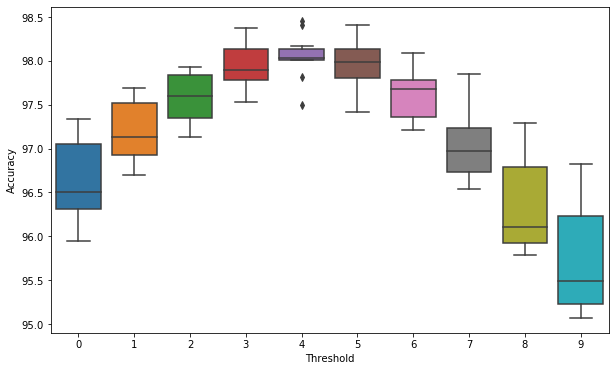

In [34]:
plt.figure(figsize=(10,6))
sns.boxplot(data=Threshold_acc_df,
            x='Threshold',
            y='Accuracy')

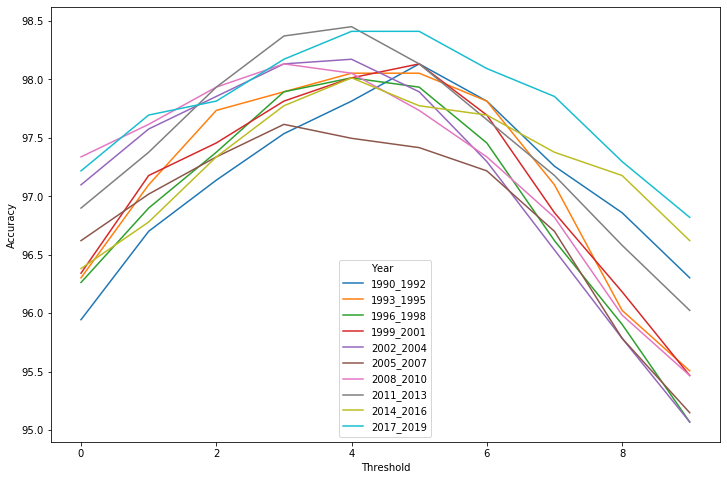

In [35]:
plt.figure(figsize=(12,8))
sns.lineplot(data=Threshold_acc_df,x='Threshold',y='Accuracy',hue='Year')

##### Observe that using the threshold of 4  increses the classification accuracy by 3 or 4 percent, but the increase is not so obvious at the end of years

Prepare the original Accuracy df

In [16]:
# import the original accuracy df
original_acc_landsat  = pd.read_csv('../Sub_Process_7_Classification_on_img/Result/Classification_Accuracy.csv')
original_acc_sentinle = pd.read_csv('../Sub_Process_7_Classification_on_img/Result/Classification_Accuracy_landsat_sentinel.csv')

In [17]:
# reconstruct the year column so we get the year_range and type
original_acc_landsat['type'] = original_acc_landsat['year'].str.split("_",expand=True)[0]
original_acc_landsat['year_range'] = original_acc_landsat['year'].str.split("_",expand=True)[[1,2]].agg('_'.join, axis=1)
original_acc_landsat = original_acc_landsat[~original_acc_landsat['year'].isin(['Landsat_2014_2016','Landsat_2017_2019'])]

original_acc_sentinle['type'] = original_acc_sentinle['year'].str.split("_",expand=True)[0]
original_acc_sentinle['year_range'] = original_acc_sentinle['year'].str.split("_",expand=True)[[1,2]].agg('_'.join, axis=1)

In [18]:
#  concate the original acc df
original_acc = pd.concat([original_acc_landsat,original_acc_sentinle])

In [19]:
Threshold_acc_df

,Year,Threshold,Feature,Sample_size,Correct_num,Accuracy
0,1990_1992,0,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1909,96.414141
1,1990_1992,1,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1916,96.767677
2,1990_1992,2,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1930,97.474747
3,1990_1992,3,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1938,97.878788
4,1990_1992,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1944,98.181818
...,...,...,...,...,...,...
95,2017_2019,5,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1949,96.628656
96,2017_2019,6,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1945,96.430342
97,2017_2019,7,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1940,96.182449
98,2017_2019,8,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1928,95.587506


Prepare the threshold df

In [20]:
Threshold_acc = Threshold_acc_df[Threshold_acc_df['Threshold']==4].copy()

Threshold_acc['type'] = Threshold_acc['Year'].str.split("_",expand=True)[0]
Threshold_acc['year_range'] = Threshold_acc['Year']

In [21]:
Threshold_acc

,Year,Threshold,Feature,Sample_size,Correct_num,Accuracy,type,year_range
4,1990_1992,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1944,98.181818,1990,1990_1992
14,1993_1995,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1929,97.424242,1993,1993_1995
24,1996_1998,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1923,97.121212,1996,1996_1998
34,1999_2001,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1928,97.373737,1999,1999_2001
44,2002_2004,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1938,97.878788,2002,2002_2004
54,2005_2007,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1937,97.828283,2005,2005_2007
64,2008_2010,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1919,96.919192,2008,2008_2010
74,2011_2013,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",1980,1929,97.424242,2011,2011_2013
84,2014_2016,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1954,96.876549,2014,2014_2016
94,2017_2019,4,"ee.FeatureCollection({\n ""type"": ""Invocation""...",2017,1945,96.430342,2017,2017_2019


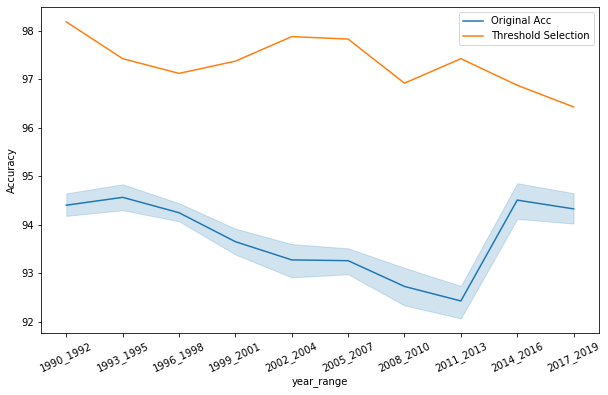

In [22]:
plt.figure(figsize=(10,6))
plt.xticks(rotation=25)

sns.lineplot(data = original_acc,
             x ='year_range',
             y ='Overall_ACC',label='Original Acc')

sns.lineplot(data =Threshold_acc,
             x ='year_range',
             y ='Accuracy',label='Threshold Selection')